In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import pandas as pd
from pyMRI.utils import RMSE

In [10]:
rerun = False
filename_end = "_3"
folder_name = "files/"

In [11]:
metabolites = pymri.METABOLITES

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")


All frequencies are captured by the sampling rate.


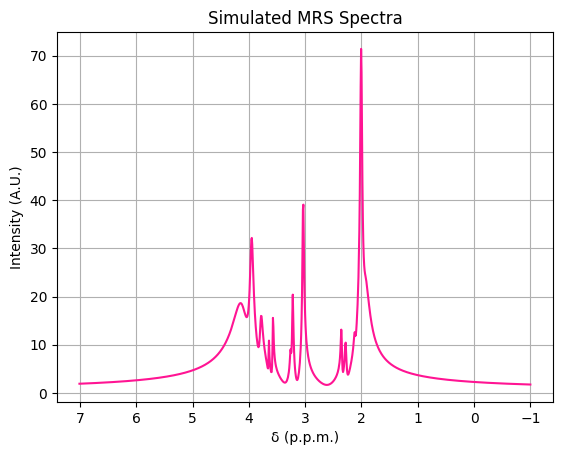

In [12]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )
pymri.plot_chem_shifts( freqs, sig_fft, 1.0 )

In [ ]:
noise_threshold = np.arange(start = 3, stop = 16, step = 1) #COMENTAR QUE A PARTIR DO START = 2 COMEÇA A CORTAR FREQUENCIAS
L = 0.4
# noise_threshold = np.power(10.0, noise_threshold)
print(noise_threshold)

[1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08 1.e-09 1.e-10 1.e-11 1.e-12
 1.e-13 1.e-14 1.e-15]


In [14]:
avgs = 10
               # (variaveis, numero de Ls, médias)
RMSEs = np.zeros((5, noise_threshold.size, avgs))


In [15]:
M_0s, spins_phi, ws, t2s = np.sort(M_0s), np.sort(spins_phi), np.sort(ws), np.sort(t2s)

if rerun == True:
    for i in range(noise_threshold.size):
        for j in range(avgs):
            reconstructed_sig, z, r = pymri.filter_sig( sig, L, noise_threshold[i], rcond=rcond, zero_filtering=zero_filtering, return_poles_and_res=True)

            s0, phi, omega, alpha = pymri.calculate_variables_from_z_and_r(z, r, dt)
            s0, phi, omega, gen_t2 = np.sort(s0), np.sort(phi), np.sort(omega), np.sort(1/alpha)

            print(phi)

            RMSEs[0, i, j] = RMSE(omega, ws)
            RMSEs[1, i, j] = RMSE(gen_t2, t2s)
            RMSEs[2, i, j] = RMSE(s0, M_0s)
            RMSEs[3, i, j] = RMSE(phi, spins_phi)
            RMSEs[4, i, j] = RMSE(np.abs(reconstructed_sig), np.abs(sig))

In [16]:
if rerun == True:
    file = open(folder_name + "svd_testing_avg" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.16f}' for x in noise_threshold) + "\n")

    avg_RMSEs = np.average(RMSEs, axis = 2)
    file.write(",".join(str(x) for x in avg_RMSEs[0, :]) + "\n")
    file.write(",".join(str(x) for x in avg_RMSEs[1, :]) + "\n")
    file.write(",".join(str(x) for x in avg_RMSEs[2, :]) + "\n")
    file.write(",".join(str(x) for x in avg_RMSEs[3, :]) + "\n")
    file.write(",".join(str(x) for x in avg_RMSEs[4, :]))

    file.close()

    file = open(folder_name + "svd_testing_std" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.16f}' for x in noise_threshold) + "\n")

    std_RMSEs = np.std(RMSEs, axis = 2)
    file.write(",".join(str(x) for x in std_RMSEs[0, :]) + "\n")
    file.write(",".join(str(x) for x in std_RMSEs[1, :]) + "\n")
    file.write(",".join(str(x) for x in std_RMSEs[2, :]) + "\n")
    file.write(",".join(str(x) for x in std_RMSEs[3, :]) + "\n")
    file.write(",".join(str(x) for x in std_RMSEs[4, :]))

    file.close()

In [17]:
# If simulation is lost
if(rerun == False):
    file_in = pd.read_csv(folder_name + "svd_testing_avg" + filename_end + ".csv")

    L = file_in.keys().to_numpy(dtype=np.float64)
    avg_RMSEs = file_in.values

    file_in = pd.read_csv(folder_name + "svd_testing_std" + filename_end + ".csv")
    std_RMSEs = file_in.values

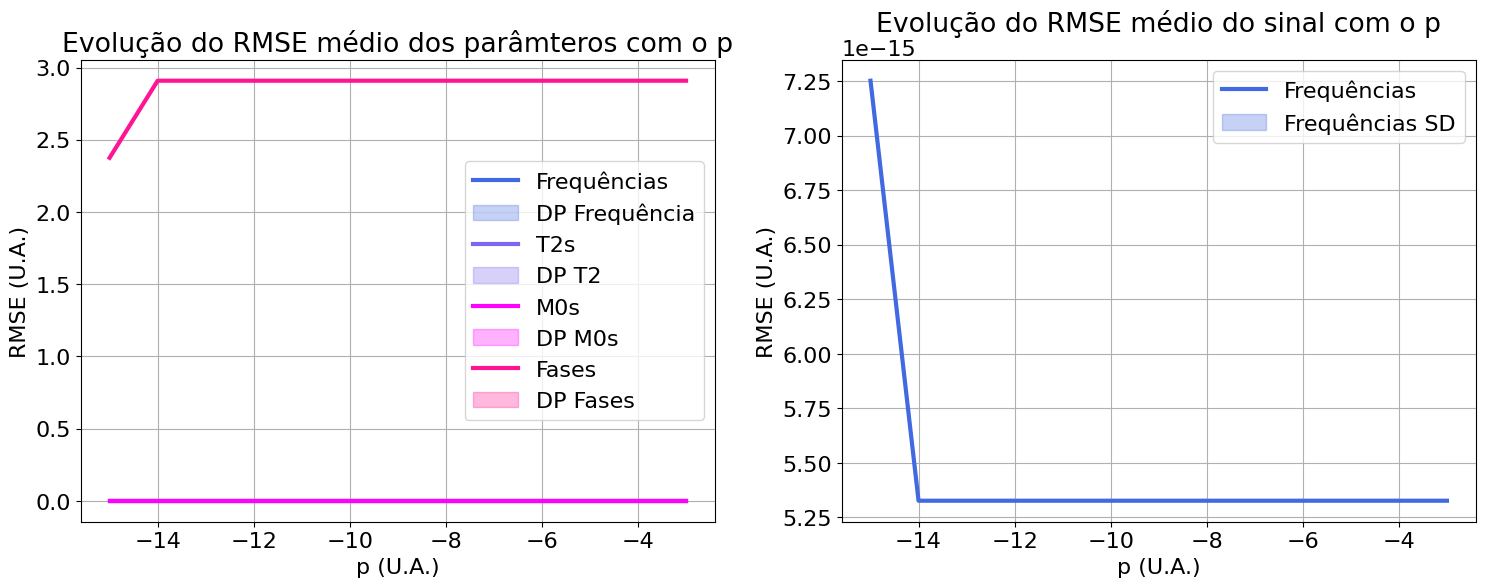

In [18]:
plt.figure(figsize=(18, 6))
plt.rcParams.update({'font.size': 16})

plt.subplot(121)
plt.plot(np.log10(noise_threshold), avg_RMSEs[0], label = "Frequências", c = "royalblue", linewidth=3)
plt.fill_between(np.log10(noise_threshold), avg_RMSEs[0] - std_RMSEs[0], avg_RMSEs[0] + std_RMSEs[0], alpha = 0.3, color = "royalblue", label = "DP Frequência")
plt.plot(np.log10(noise_threshold), avg_RMSEs[1], label = "T2s", c = "mediumslateblue", linewidth=3)
plt.fill_between(np.log10(noise_threshold), avg_RMSEs[1] - std_RMSEs[1], avg_RMSEs[1] + std_RMSEs[1], alpha = 0.3, color = "mediumslateblue", label = "DP T2")
plt.plot(np.log10(noise_threshold), avg_RMSEs[2], label = "M0s", c = "magenta", linewidth=3)
plt.fill_between(np.log10(noise_threshold), avg_RMSEs[2] - std_RMSEs[2], avg_RMSEs[2] + std_RMSEs[2], alpha = 0.3, color = "magenta", label = "DP M0s")
plt.plot(np.log10(noise_threshold), avg_RMSEs[3], label = "Fases", c = "deeppink", linewidth=3)
plt.fill_between(np.log10(noise_threshold), avg_RMSEs[3] - std_RMSEs[3], avg_RMSEs[3] + std_RMSEs[3], alpha = 0.3, color = "deeppink", label = "DP Fases")
plt.title(r"Evolução do RMSE médio dos parâmteros com o p")
plt.xlabel("p (U.A.)")
plt.ylabel("RMSE (U.A.)")
plt.grid()
plt.legend()

plt.subplot(122)
plt.title(r"Evolução do RMSE médio do sinal com o p")
plt.plot(np.log10(noise_threshold), avg_RMSEs[4], label = "Frequências", c = "royalblue", linewidth=3)
plt.fill_between(np.log10(noise_threshold), avg_RMSEs[4] - std_RMSEs[4], avg_RMSEs[4] + std_RMSEs[4], alpha = 0.3, color = "royalblue", label = "Frequências SD")
plt.xlabel(r"p (U.A.)")
plt.ylabel(r"RMSE (U.A.)")
plt.grid()
plt.legend()